In [7]:
import os
from itertools import chain, compress
import random
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import train_test_split
from settings import EEGSettings
import eeg_lib
import importlib
importlib.reload(eeg_lib)
from eeg_lib import  create_dataset, load_data, predict_lm, predict_lgbm, plot_patterns, plot_clusters, plot_roc_curves, plot_feature_importance

In [8]:
import glob

In [3]:
import re

In [11]:
import pickle
import mne
import numpy as np
from itertools import compress
import h5io
from joblib import Parallel, delayed
from tqdm import tqdm

from scipy import stats
from matplotlib import pyplot as plt, cm
from mne.decoding import LinearModel, get_coef
from mne.stats import permutation_cluster_test
from mne.time_frequency import psd_multitaper
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [60]:
###

path = '/Users/ilyamikheev/Downloads/128_CHANNEL_split_REST_open_for_Ilia (314 c 319 сравнить)'
chan_drop = ['E8', 'E14', 'E17', 'E21', 'E25', 'E43', 'E44',
                                                                 'E48', 'E49', 'E56', 'E57', 'E63', 'E64', 'E65', 'E68',
                                                                 'E69', 'E73', 'E74', 'E81', 'E82', 'E88', 'E89', 'E90',
                                                                 'E94', 'E95', 'E99', 'E100', 'E107', 'E113', 'E114',
                                                                 'E119', 'E120', 'E125', 'E126', 'E127', 'E128']
montage = mne.channels.make_standard_montage('GSN-HydroCel-128')
events_list = [241,242,244]
fr_bands = {   "theta1":  [4,6],
               "theta2":  [6,8],
               "alpha1": [8,10],
               "alpha2": [10,12],
               "beta1":  [12,16],
               "beta2":  [16,20],
               "beta3":  [20,24]}
dict_cls = { "241/244": [0,2],
             "242/244": [1,2],
             "241/242": [0,1] }
files = [f for f in sorted(os.listdir(path))]
_ = files.pop(0)
indexes = []
for i,j in enumerate(files):
    indexes.append(re.search('(.+?)_', j).group(1))

mat = ['311', '312', '316', '317', '330', '334']

not_mat = ['313', '324', '331', '332', '337', '336']
index_mat, index_not_mat = [indexes.index(i) for i in mat], [indexes.index(i) for i in not_mat]
subj_list_table, subj_list_features, e_list = [], [], []

In [5]:
def eeg_power_band(epochs_list):
    fin_table, fin_feat = [], []
    for beta in range(len(epochs_list)):
        psds, freqs = psd_multitaper(epochs_list[beta])
        psds_table = np.mean(psds, axis=0)
        psds /= psds.sum(axis=-1)[..., None]
        psds_table /= psds_table.sum(axis=-1)[..., None]
        psd_table_list, psd_features_list = [], []
        for fmin, fmax in fr_bands.values():
            freq_mask = (fmin < freqs) & (freqs < fmax)
            data_table, data_feat = psds_table[..., freq_mask].mean(axis=-1), psds[..., freq_mask].mean(axis=-1)
            psd_features_list.append(data_feat)
            psd_table_list.append(data_table)
        fin_table.append(psd_table_list)
        fin_feat.append(psd_features_list)
    return fin_feat, fin_table

In [61]:
path = '/Users/ilyamikheev/Downloads/128_CHANNEL_split_REST_open_for_Ilia (314 c 319 сравнить)'

subj_list_table, subj_list_features, e_list = [], [], []
for file_name in files:
    paths = glob.glob(path + '/{0}/*.edf'.format(file_name))
    epochs_list = []
    j = 0
    for i in paths:
        event_id = dict(a='0')
        raw = mne.io.read_raw_edf(i)
        if 'Markers' in raw.ch_names:
           raw.drop_channels(['Markers'])
        else:
           raw.drop_channels(['Status'])
        if  len(raw.times)//250 < 10:
            continue
        new_events = mne.make_fixed_length_events(raw, id=0, start=0, duration=2, overlap=0)
        if j==1:
            epochs = mne.concatenate_epochs([mne.Epochs(raw, new_events, event_id = 0, tmin=0,
                                                        tmax=2, baseline=None, flat=dict(eeg=1e-20),
                                                        preload=True), epochs])
        else:
            epochs = mne.Epochs(raw, new_events, event_id = 0 , tmin=0, tmax=2, baseline=None,
                                flat=dict(eeg=1e-20), preload=True)
            j+=1
    epochs_list.append(epochs.copy())
    for teta in range(len(epochs_list)):
            new_names = {}
            new_names = dict(
                    (ch_name,
                     ch_name.replace('-', '').replace('Chan ', 'E').replace('CAR', '').replace('EEG ', '')
                     .replace('CA', '').replace(' ', ''))
                     for ch_name in epochs_list[teta].ch_names)
            epochs_list[teta].rename_channels(new_names).set_montage(montage).drop_channels(chan_drop)
    e_list.append(epochs_list)
    feat_list, tabl_list = eeg_power_band(epochs_list)
    subj_list_table.append(tabl_list)
    subj_list_features.append(feat_list)
chan1 = epochs_list[0].ch_names

Extracting EDF parameters from /Users/ilyamikheev/Downloads/128_CHANNEL_split_REST_open_for_Ilia (314 c 319 сравнить)/311_Math_rest_open/311_Math_rest_open_n_7_m_212_t_215_eda_0_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Loading data for 8 events and 1001 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /Users/ilyamikheev/Downloads/128_CHANNEL_split_REST_open_for_Ilia (314 c 319 сравнить)/311_Math_rest_open/311_Math_rest_open_n_14_m_212_t_215_eda_0_.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Loading data for 8 events and 1001 original time points ...
1 bad epochs dropped
Not setting metadata
14 matching events found
No baseline correction applied
0 bad epochs

In [66]:
test_set = np.concatenate([x_tf[i][0] for i in range(5)])
shap_values = np.concatenate([sh_v[i][0][1] for i in range(5)])

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


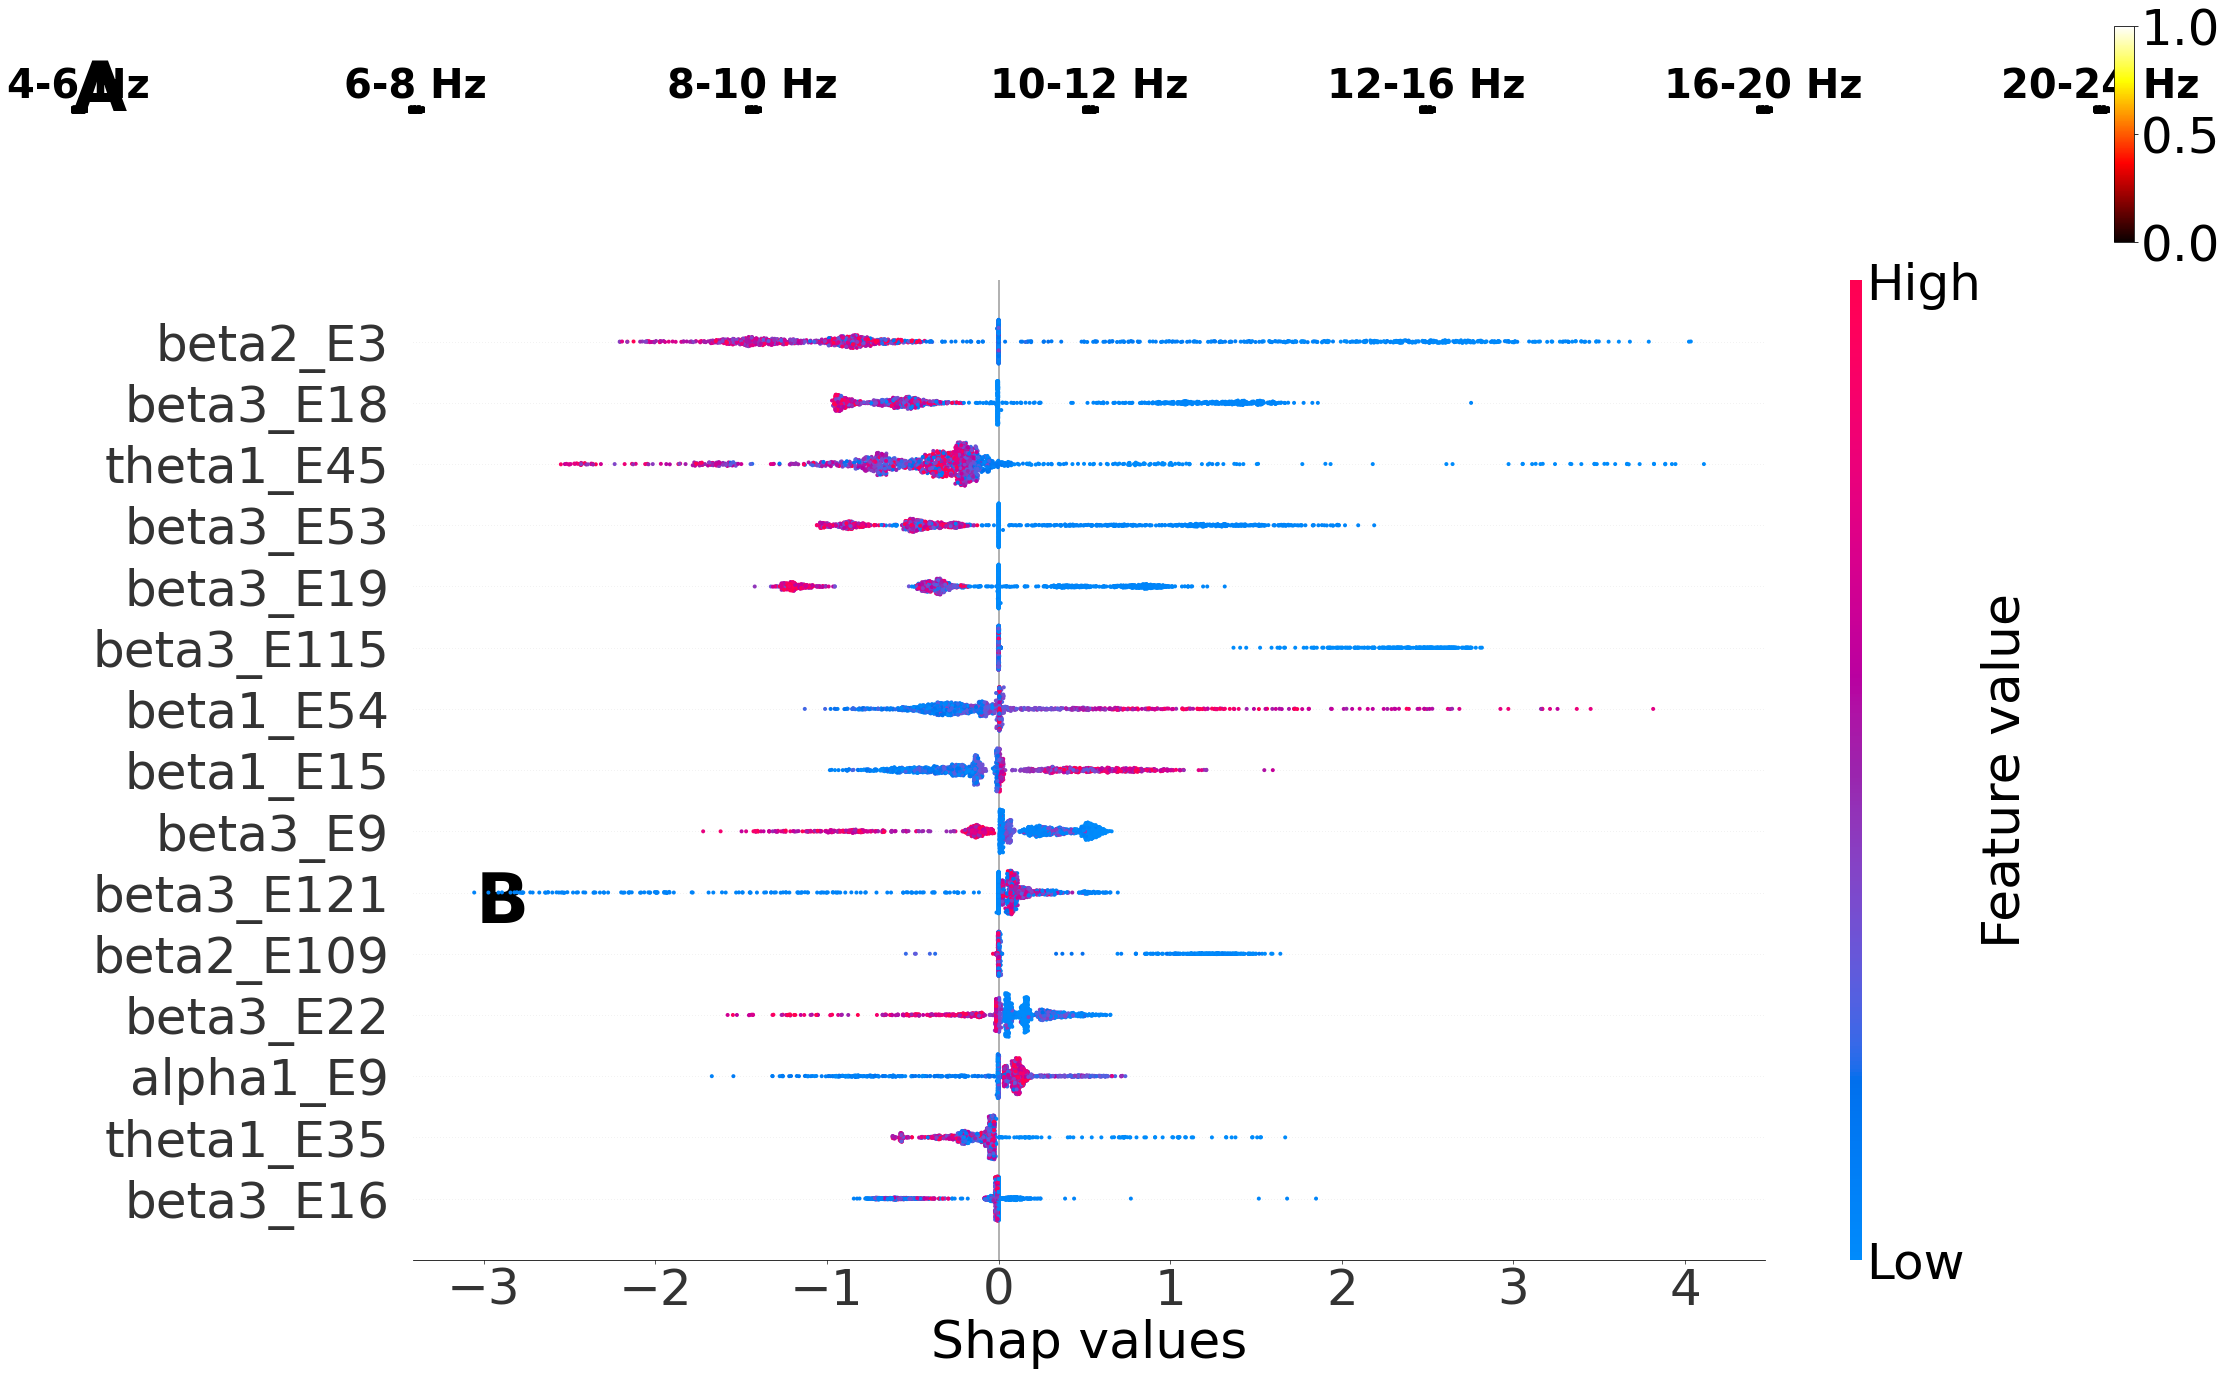

In [69]:
fig = plt.figure(figsize=(30, 20))
plt.tight_layout()
grid = plt.GridSpec(4, 7)
for i, key in enumerate(list(settings.fr_bands.keys())):
        plt.subplot(grid[0, i])
        if i == 0:
            plt.text(-0.25, 0, f'A', fontdict={'fontsize': 70, 'fontweight': 'semibold'})
        mne.viz.plot_topomap(np.abs(shap_values[:, (92*(i)):((i+1)*92)]).mean(0).round(2), info1, cmap='hot', show=False, names=chan1, show_names=True)
        plt.subplot(grid[0, i]).set_title(label=f'{settings.fr_bands[key][0]}-{settings.fr_bands[key][1]} Hz',
                          fontdict={'fontsize': 40, 'fontweight': 'semibold'})

m = cm.ScalarMappable(cmap='hot')
coord = [1, 0.79, 0.009, 0.15]
cax = fig.add_axes(coord)
m.set_array(np.array([0, 1]))
plt.colorbar(m, cax, fraction=0.051, pad=0.012 )
plt.tick_params(axis='both', which='major', labelsize=50)
plt.tight_layout()
plt.subplot(grid[1:, 1:])
plt.text(-3.05, 4.5, f'B', fontdict={'fontsize': 70, 'fontweight': 'semibold'})
shap.summary_plot(shap_values, test_set, feature_names=[f'{i}_{j}' for i in list(settings.fr_bands.keys()) for j in chan1], show=False, max_display = 15, plot_size=(30,20))
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(axis='both', which='major', labelsize=50)
fig.axes[-1].tick_params(axis='both', which='major', labelsize=50)
fig.axes[-1].set_ylabel('Feature value', fontsize=52)
ax.set_xlabel('Shap values', fontsize=52)
plt.tight_layout()
plt.show()

In [101]:
[len(i[0]) for i in metrics_d['lgbm_gr']['pr_v']]

[260, 287, 308, 287, 254, 265]

In [ ]:
[len(i[0]) for i in metrics_d['lgbm_gr']['pr_v']]

In [ ]:
['aucs']

In [99]:
metrics_d['lgbm_gr']['aucs']

[[0.5604167900065123],
 [0.9705053449951409],
 [0.9618622448979591],
 [0.9968264817888879],
 [0.6773131175045051],
 [0.34968102073365226]]

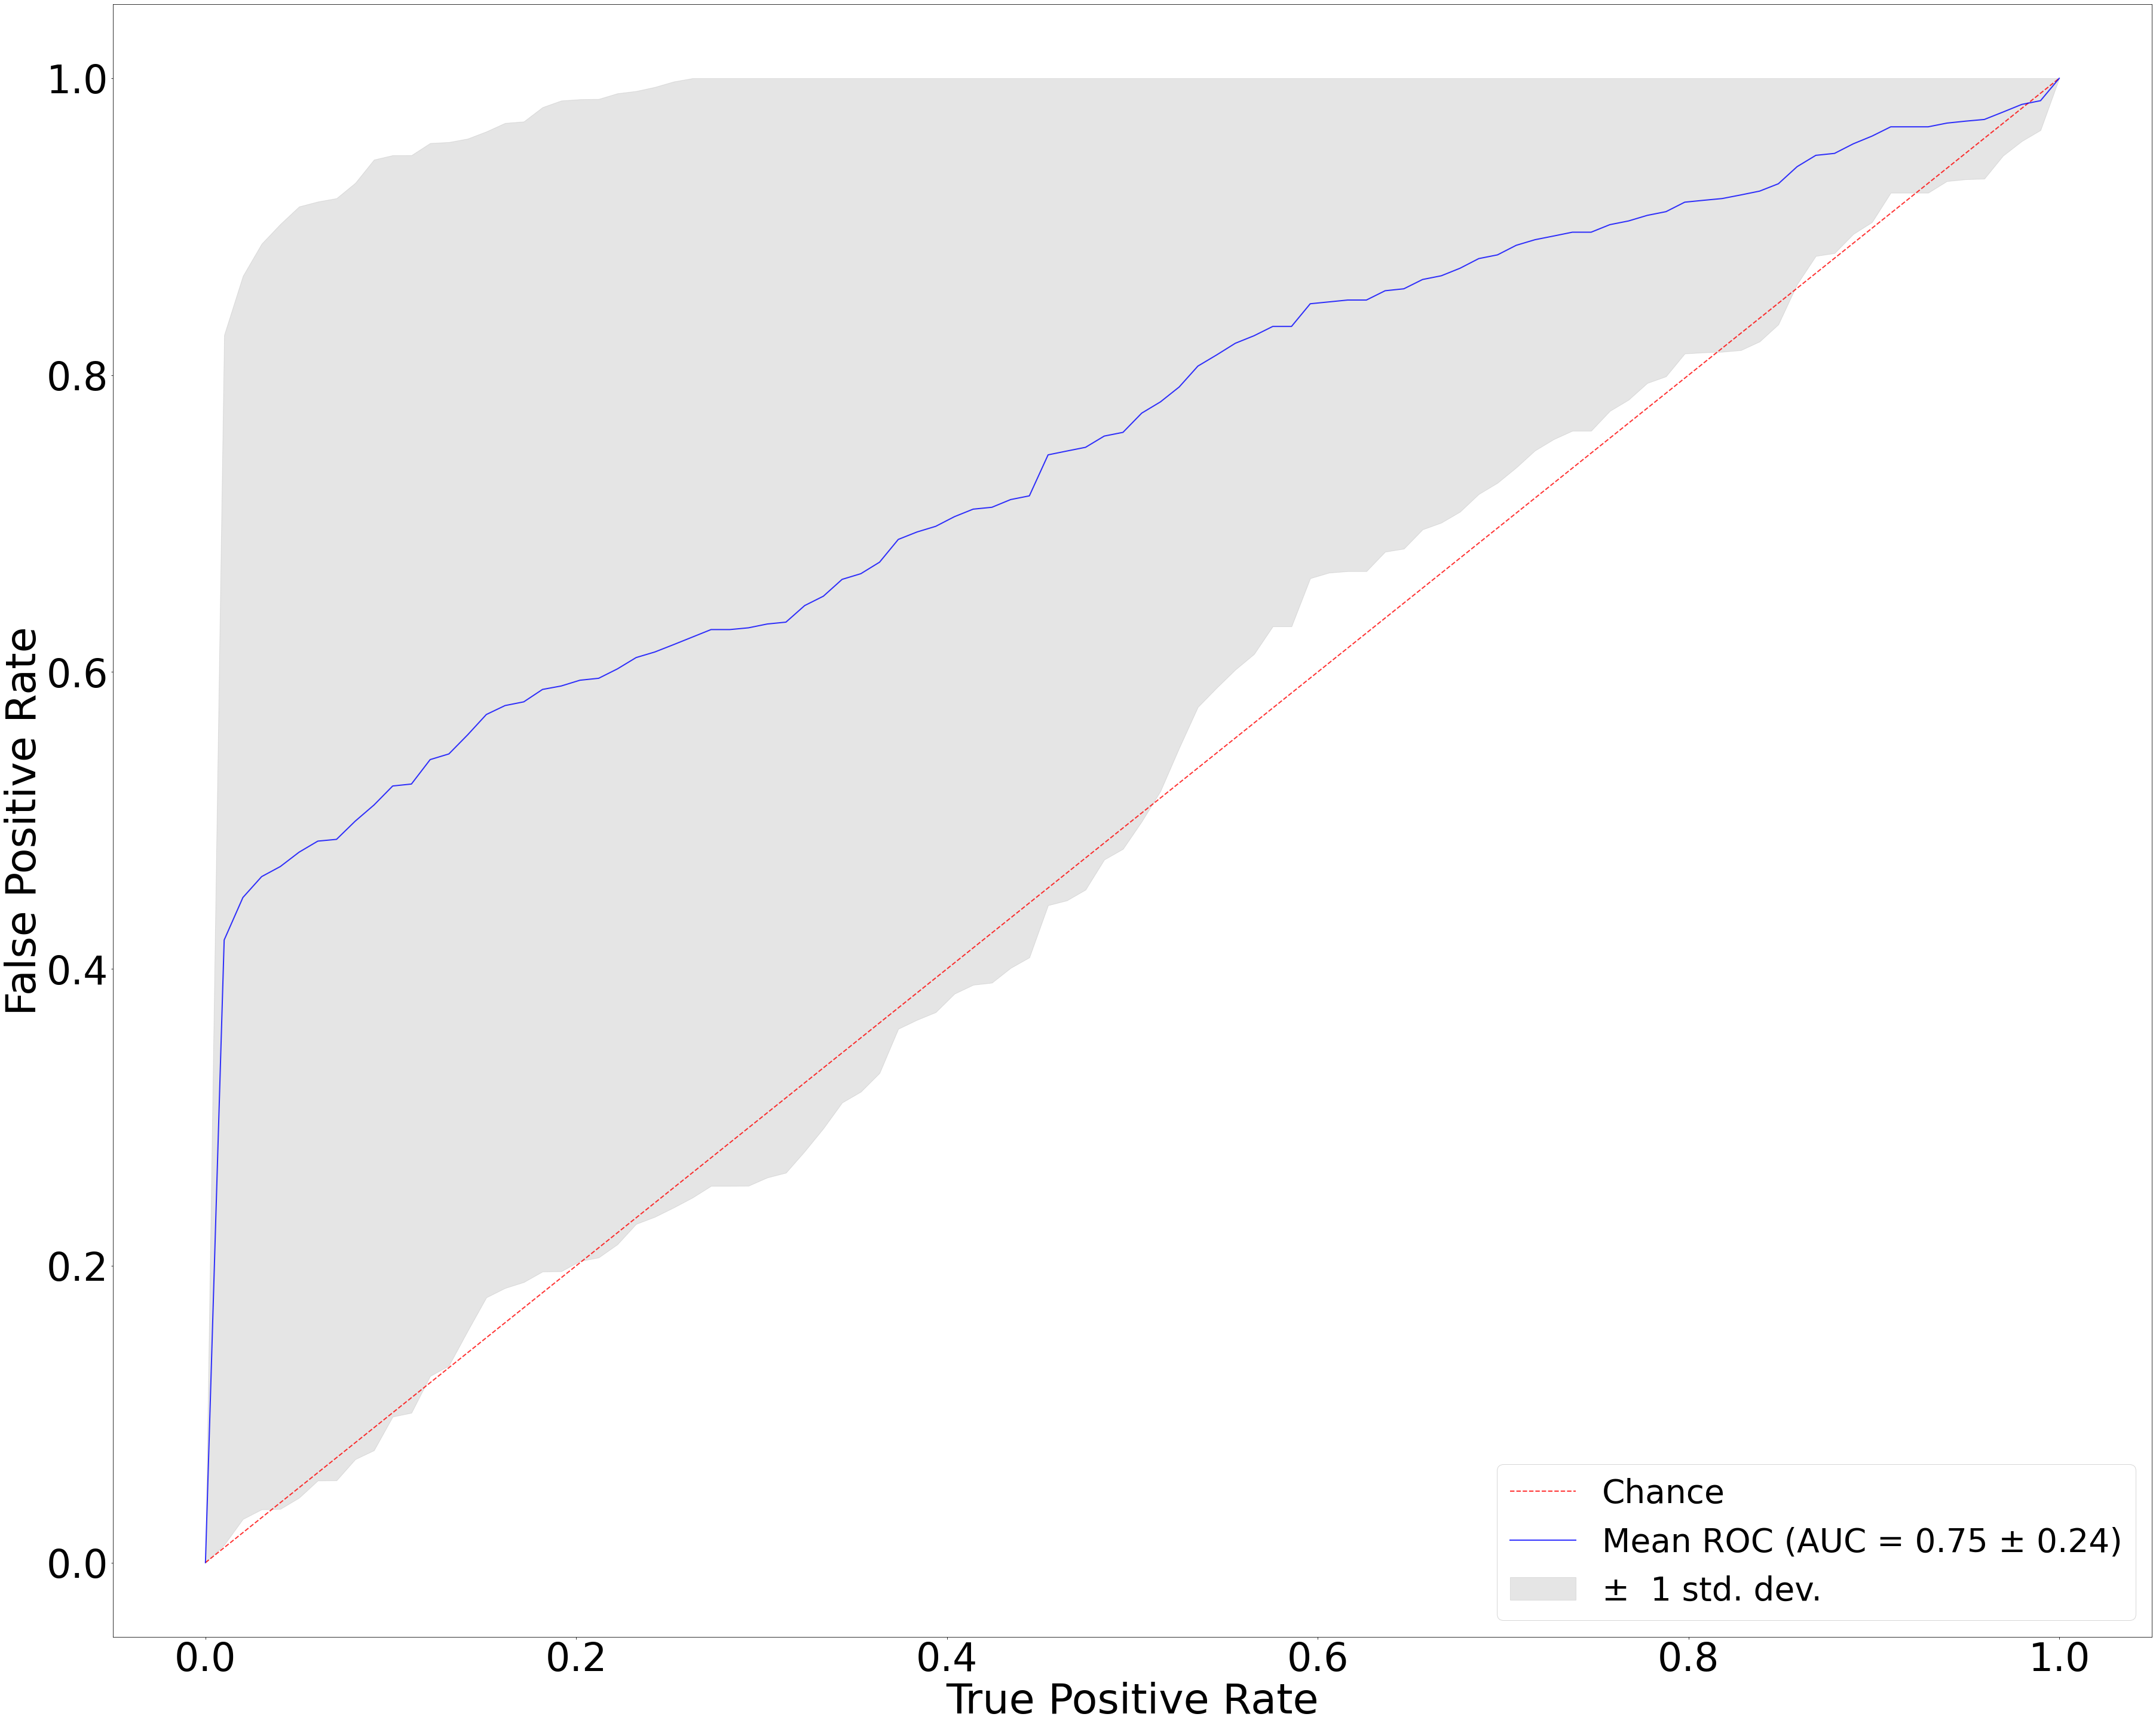

In [106]:
fig = plt.figure(constrained_layout=True, figsize=(50,40))
s_ind = [i for i in range(6)]
subfigs = fig.subfigures(1, 1, wspace=0.07)
axs_right = subfigs.subfigures(1, 1)
ax = axs_right
ax = ax.subplots(nrows=1, ncols=1)
eeg_lib.plot_roc_curves([metrics_d['lgbm_gr']['tprs'][i][0] for i in s_ind], [metrics_d['lgbm_gr']['aucs'][i][0] for i in s_ind],
                [metrics_d['lgbm_gr']['pr_v'][i][0] for i in s_ind], [metrics_d['lgbm_gr']['true_v'][i][0] for i in s_ind],
                plot_all=False, ax=ax)

In [107]:
fig.savefig(f'Results/lgbm_rest_auc.png', format='png', bbox_inches='tight', dpi=300)

Text(0.5, 100.5, 'Shap values')

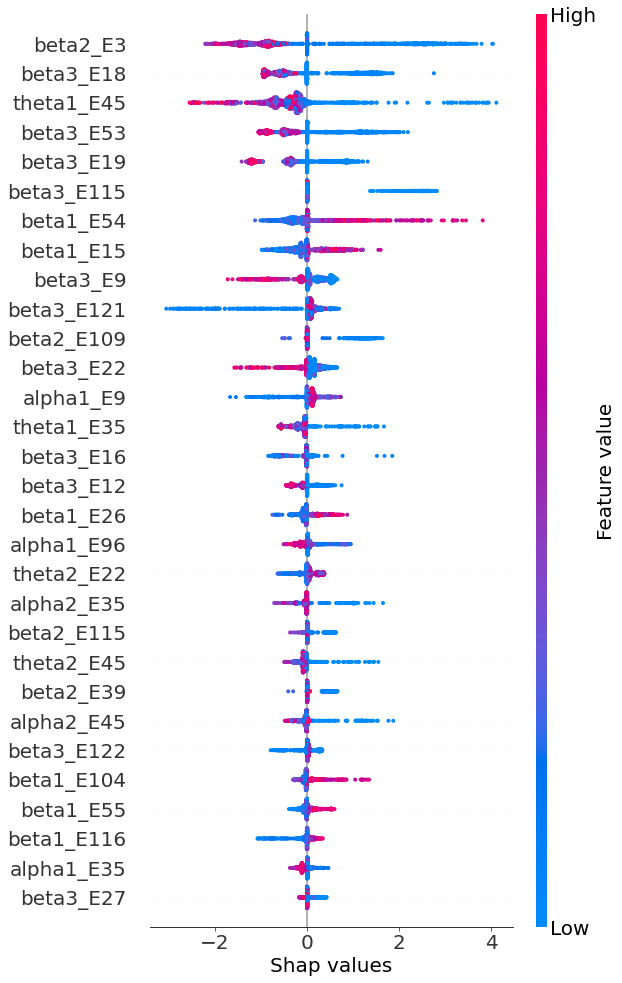

In [77]:
shap.summary_plot(shap_values, test_set, feature_names=[f'{i}_{j}' for i in list(settings.fr_bands.keys()) for j in chan1], show=False, max_display = 30)
fig, ax = plt.gcf(), plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)
fig.axes[-1].tick_params(axis='both', which='major', labelsize=20)
fig.axes[-1].set_ylabel('Feature value', fontsize=20)
ax.set_xlabel('Shap values', fontsize=20)

In [79]:
fig.savefig(f'Results/lgbm_rest_imp.png', format='png', bbox_inches='tight', dpi=300)

In [27]:
subj_list_features

[[[array([[0.04286991, 0.06812956, 0.02806685, ..., 0.07613308, 0.06784714,
           0.05588675],
          [0.0864732 , 0.05031747, 0.05910059, ..., 0.0646632 , 0.06264382,
           0.06612531],
          [0.0836165 , 0.07191319, 0.0444568 , ..., 0.04317425, 0.02967348,
           0.03412508],
          ...,
          [0.05758816, 0.08431872, 0.05037624, ..., 0.06022533, 0.04566824,
           0.03584154],
          [0.07261409, 0.05446079, 0.046656  , ..., 0.03395515, 0.04320223,
           0.04778218],
          [0.03109732, 0.04286885, 0.03625088, ..., 0.04478474, 0.0370518 ,
           0.04007369]]),
   array([[0.04289467, 0.0406241 , 0.02712848, ..., 0.03879391, 0.04355093,
           0.05205135],
          [0.01599532, 0.03288227, 0.03867811, ..., 0.03778528, 0.05144574,
           0.06042792],
          [0.04647253, 0.03687271, 0.03624987, ..., 0.04339142, 0.03114838,
           0.02875914],
          ...,
          [0.0316823 , 0.05014104, 0.03467598, ..., 0.03884664, 0.04

In [56]:
info = epochs_list[0].info
info1 = mne.create_info(info.ch_names, ch_types= 'eeg',
                        sfreq = 250)
info1.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E9, E10, E11, E12, E13, E15, E16, ...
 chs: 95 EEG
 custom_ref_applied: False
 dig: 98 items (3 Cardinal, 95 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 95
 projs: []
 sfreq: 250.0 Hz
>

In [47]:
import shap
def predict_lgbm(data, eeg_param, ps=None):
    """
    function for LightGBM model
    Parameters
    ----------
    data: list[np.ndarray]
    eeg_param: list[dict, list]
        [fr_bands, channels_names]
    Returns
    -------
    :rtype: tuple
    :return: ac, roc_auc, interp_tpr, feature_importances, y_predict_pr
    """
    mean_fpr = np.linspace(0, 1, 100)
    sc = StandardScaler()
    data[0] = sc.fit_transform(data[0])
    data[1] = sc.transform(data[1])
    fit_params = {'objective': 'binary', 'num_leaves': 30}
    m = lgbm(**fit_params)
    param_grid = {'reg_lambda': [0.5]}
    if ps is None:
        ps = 5
    model = GridSearchCV(m, param_grid, cv=ps)
    model.fit(data[0], data[2])
    feature_importances = ((model.best_estimator_.feature_importances_ / sum(model.best_estimator_
                                                                             .feature_importances_)) * 100).reshape(
        (len(eeg_param[0]), len(eeg_param[1])))
    y_predict, y_predict_pr = model.predict(data[1]), model.predict_proba(data[1])
    shap_values = shap.TreeExplainer(model.best_estimator_).shap_values(data[1])
    ac = balanced_accuracy_score(data[3], y_predict)
    fpr, tpr, _ = roc_curve(data[3], y_predict_pr[:, 0], pos_label=0)
    roc_auc, interp_tpr = auc(fpr, tpr), np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return ac, roc_auc, interp_tpr, feature_importances, y_predict_pr, shap_values, data[1]

In [14]:
settings = EEGSettings(path=path)

In [63]:
data = {}
data['spectra_feat'] = spectra_feat

In [24]:
data['spectra_feat']

[]

In [17]:
index_all = index_mat + index_not_mat

In [18]:
import eeg_lib
import os
from itertools import chain
import random
import numpy as np
import pandas as pd
import mne
import coffeine
import pyriemann
import itertools
import pickle
from sklearn.model_selection import train_test_split, PredefinedSplit

import pickle
import importlib

importlib.reload(eeg_lib)
from settings import EEGSettings
from eeg_lib import create_dataset, load_data, predict_lm, predict_lgbm, plot_clusters, merge_fig
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import mne
import numpy as np
from itertools import compress

from scipy import stats
from matplotlib import pyplot as plt, cm
from mne.decoding import LinearModel, get_coef
from mne.stats import permutation_cluster_test
from mne.time_frequency import psd_multitaper
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, minmax_scale
from tqdm import tqdm
from lightgbm import LGBMClassifier as lgbm

import pickle
import mne
import numpy as np
from itertools import compress

from scipy import stats
from matplotlib import pyplot as plt, cm
from mne.decoding import LinearModel, get_coef
from mne.stats import permutation_cluster_test
from mne.time_frequency import psd_multitaper
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import balanced_accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, minmax_scale
from tqdm import tqdm
from lightgbm import LGBMClassifier as lgbm

In [19]:
anova_d = {}
metrics_d = {}

In [34]:
len(data['spectra_feat'][0][0][0][0])

95

In [88]:
results = np.zeros((len(index_mat), 2))
feat_import = np.zeros((len(index_mat), 3, 7, len(chan1)))
metrics = {k: [] for k in ['tprs', 'aucs', 'true_v', 'pr_v']}
sh_v = []
x_tf = []
for count, (s_ind_1, s_ind_2) in tqdm(enumerate(zip(index_mat, index_not_mat)), total=len(index_mat),
                                      desc=f'Evaluation for {len(index_mat)} folds', position=0):
    metrics_loop = {k: [] for k in range(4)}
    sh_v1 = []
    x_t1 = []
        # subjects for cv
    s_ind_1_cv, s_ind_2_cv = random.choice([i for i in index_mat if i != s_ind_1]), random.choice(
        [i for i in index_not_mat if i != s_ind_2])
    y_train = [1] * sum(
        [data['spectra_feat'][i][0].shape[0] for i in index_mat if i not in [s_ind_1_cv, s_ind_1]]) + [0] * sum(
        [data['spectra_feat'][i][0].shape[0] for i in index_not_mat if i not in [s_ind_2_cv, s_ind_2]])
    x_train = np.concatenate(
        [data['spectra_feat'][i][0] for i in index_all if i not in [s_ind_1_cv, s_ind_2_cv, s_ind_1, s_ind_2]],
        axis=0).reshape(len(y_train), -1)
    y_val = [1] * data['spectra_feat'][s_ind_1_cv][0].shape[0] + [0] * data['spectra_feat'][s_ind_2_cv][0].shape[0]
    x_val = np.concatenate([data['spectra_feat'][i][0] for i in [s_ind_1_cv, s_ind_2_cv]], axis=0).reshape(len(y_val), -1)
    y_test = [1] * data['spectra_feat'][s_ind_1][0].shape[0] + [0] * data['spectra_feat'][s_ind_2][0].shape[0]
    x_test = np.concatenate([data['spectra_feat'][i][0] for i in [s_ind_1, s_ind_2]], axis=0).reshape(len(y_test),
                                                                                                        -1)
    x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.01)
    ps = PredefinedSplit(np.concatenate([np.zeros(len(x_train)) - 1, np.ones(len(x_val))]))
    x_train, y_train = np.concatenate((x_train, x_val), axis=0), y_train + y_val
    ac, roc_auc, interp_tpr, coef_ev, y_predict_pr, s_v, x_t = predict_lgbm([x_train, x_test, y_train, y_test],
    [settings.fr_bands, chan1], ps=ps)
    sh_v1.append(s_v)
    x_t1.append(x_t)
    results[count, ...] = ac, roc_auc
    feat_import[count, ...] = coef_ev
    for k, v in zip(metrics_loop.keys(), [interp_tpr, roc_auc, y_test, y_predict_pr]):
        metrics_loop[k].append(v)
    sh_v.append(sh_v1)
    x_tf.append(x_t1)
    for k, v in zip(metrics.keys(), metrics_loop.values()):
        metrics[k].append(v)

anova_d['lgbm_gr'] = results
metrics_d['lgbm_gr'] = metrics

Evaluation for 6 folds: 100%|██████████| 6/6 [00:15<00:00,  2.64s/it]


In [65]:
results

array([[0.5       , 0.50778521],
       [0.9164966 , 0.9739553 ],
       [0.89821429, 0.96118197],
       [0.9531784 , 0.99467825],
       [0.5       , 0.70595911],
       [0.4924812 , 0.40088859]])

In [62]:
spectra_feat = [[np.stack(subj_list_features[i][0], axis=1)] for i in range(len(files))]

In [42]:
len(spectra_feat)

1

In [43]:
spectra_feat[0][0].shape

(133, 7, 95)

In [ ]:
l_lens = np.zeros((26,1))

for i in range(len(indexes)):
      l_lens[i] = len(e_list[i][0])
e_list[0]

df_subj = pd.DataFrame(l_lens, columns=['epochs'], index=indexes)
writer = pd.ExcelWriter(os.path.join('/Users/ilyamikheev/Downloads', 'subjects_epochs_128.xlsx'))
df_subj.to_excel(writer)
writer.save()

In [8]:
from sklearn.metrics import balanced_accuracy_score

In [40]:
from sklearn.metrics import roc_curve
from sklearn import metrics

In [199]:
list_A, list_B = [], []
#index_mat, index_not_mat = [indexes.index(i) for i in mat], [indexes.index(i) for i in not_mat]
#new_mat = ['314', '326', '327', '328', '335', '315']
#new_not_mat = ['318','319','320','322','333','329']
#new_mat = ['311', '312', '316', '317', '330', '334']
#new_not_mat = ['313','324','331','332','337','336']
#new_mat = ['326', '330', '316', '328', '314', '335', '327', '312', '317', '334']
#new_not_mat = ['333', '320', '319', '336', '331', '323', '313', '324', '325', '337']
new_mat = ['311', '316', '312', '334', '313', '332', '324', '337']
new_not_mat = ['314','327','326','335','329','319', '318', '320']

index_mat, index_not_mat = [indexes.index(i) for i in new_mat], [indexes.index(i) for i in new_not_mat]
all_indexes = index_mat + index_not_mat
coefs_group = np.zeros((4,10,2,len(fr_bands),len(chan1)))
results_group = np.zeros((10,2))
#all_indexes_table = mat + not_mat
#all_indexes = np.array(all_indexes)
index_mat, index_not_mat = np.array(index_mat), np.array(index_not_mat)
ind = 0
im1 = []
tprs = []
aucs = []
fprl = []
tprl = []
for count, (s_ind_1, s_ind_2) in enumerate(zip(index_mat, index_not_mat)):
    mean_fpr = np.linspace(0, 1, 100)
    A =  np.concatenate(([np.stack([subj_list_features[j] for j in index_mat[index_mat!=s_ind_1]][i][ind],axis = 1)
                      for i in range(index_mat[index_mat!=s_ind_1].shape[0])]),axis=0)
    B =  np.concatenate(([np.stack([subj_list_features[j] for j in index_not_mat[index_not_mat!=s_ind_2]][i][ind],axis = 1)
                      for i in range(index_not_mat[index_not_mat!=s_ind_2].shape[0])]),axis=0)
    C1 = np.stack(subj_list_features[s_ind_1][ind], axis = 1)
    C2 = np.stack(subj_list_features[s_ind_2][ind], axis = 1)
    x_train = np.concatenate((A,B),axis=0)
    y_train = [0]*A.shape[0] + [1]*B.shape[0]
    x_test = np.concatenate((C1, C2),axis=0)
    y_test = [0]*C1.shape[0] + [1]*C2.shape[0]
    x_train = x_train.reshape(x_train.shape[0],-1)
    x_test = x_test.reshape(x_test.shape[0],-1)
    # test size 0.2
    x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.1)
    sc = StandardScaler()
    sc.fit(x_train)
    x_train = sc.transform(x_train)
    x_test = sc.transform(x_test)
    lgb = LGBMClassifier(objective='binary')
    lgb.fit(x_train, y_train)
    feature_importances = (lgb.feature_importances_ / sum(lgb.feature_importances_)) * 100
    im1.append(feature_importances)
    predictions = lgb.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, predictions[:,0], pos_label=0)
    fprl.append(predictions)
    tprl.append(y_test)
    roc_auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    auc = roc_auc_score(y_test, predictions[:,1])
    ac = balanced_accuracy_score(y_test, lgb.predict(x_test))
    results_group[count, 0] = ac
    results_group[count, 1] = auc

In [207]:
results_group = pd.DataFrame(results_group, columns = ['accuracy', 'auc'] )

In [42]:
results_group

array([[0.5       , 0.46474454],
       [0.92176871, 0.98804665],
       [0.8577381 , 0.92342687],
       [0.94993165, 0.99209062],
       [0.5       , 0.7160256 ],
       [0.4962406 , 0.31704261],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]])

In [200]:
def plot_topo(ar, info):
    #vmin = np.amin(ar)
    vmin = 0
    vmax = np.amax(ar)
    fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(30, 20))
    ss = 0
    for i, key in enumerate(list(fr_bands.keys())):
        if i in range(7):
            evoked = mne.EvokedArray(ar[i,:].reshape(-1,1),
                             info, tmin=0.)
            a = evoked.plot_topomap(axes=axes[ss], time_format=None, colorbar = False,  times=[0], cmap='hot',
                                    size = 5, show_names = False, vmin = 0, show = False)
            axes[ss].set_title(label = '{}-{} Hz'.format(*fr_bands[key]), fontdict = {'fontsize': 40, 'fontweight' : 'semibold'})
            mne.viz.tight_layout()
            ss+=1
    m = cm.ScalarMappable(cmap='hot')
    m.set_array([vmin, vmax])
    cax = fig.add_axes([1, 0.3, 0.03, 0.38])
    cb = fig.colorbar(m, cax)
    cb.ax.tick_params(labelsize=40)
    plt.figtext(0.5, 0.7, '{}'.format('Features importance'), va="center", ha="center", size=60, fontweight = 'semibold')
    return fig

In [43]:
from itertools import compress

In [201]:
a_l = list(compress(im1, results_group [:,1]>0.5))
fin_ar = np.mean(a_l, axis=0).reshape((7,95))

In [68]:
info = epochs_list[0].info
info1 = mne.create_info(info.ch_names, ch_types= 'eeg',
                        sfreq = 250)
info1.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E9, E10, E11, E12, E13, E15, E16, ...
 chs: 92 EEG
 custom_ref_applied: False
 dig: 95 items (3 Cardinal, 92 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 92
 projs: []
 sfreq: 250.0 Hz
>

/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhu

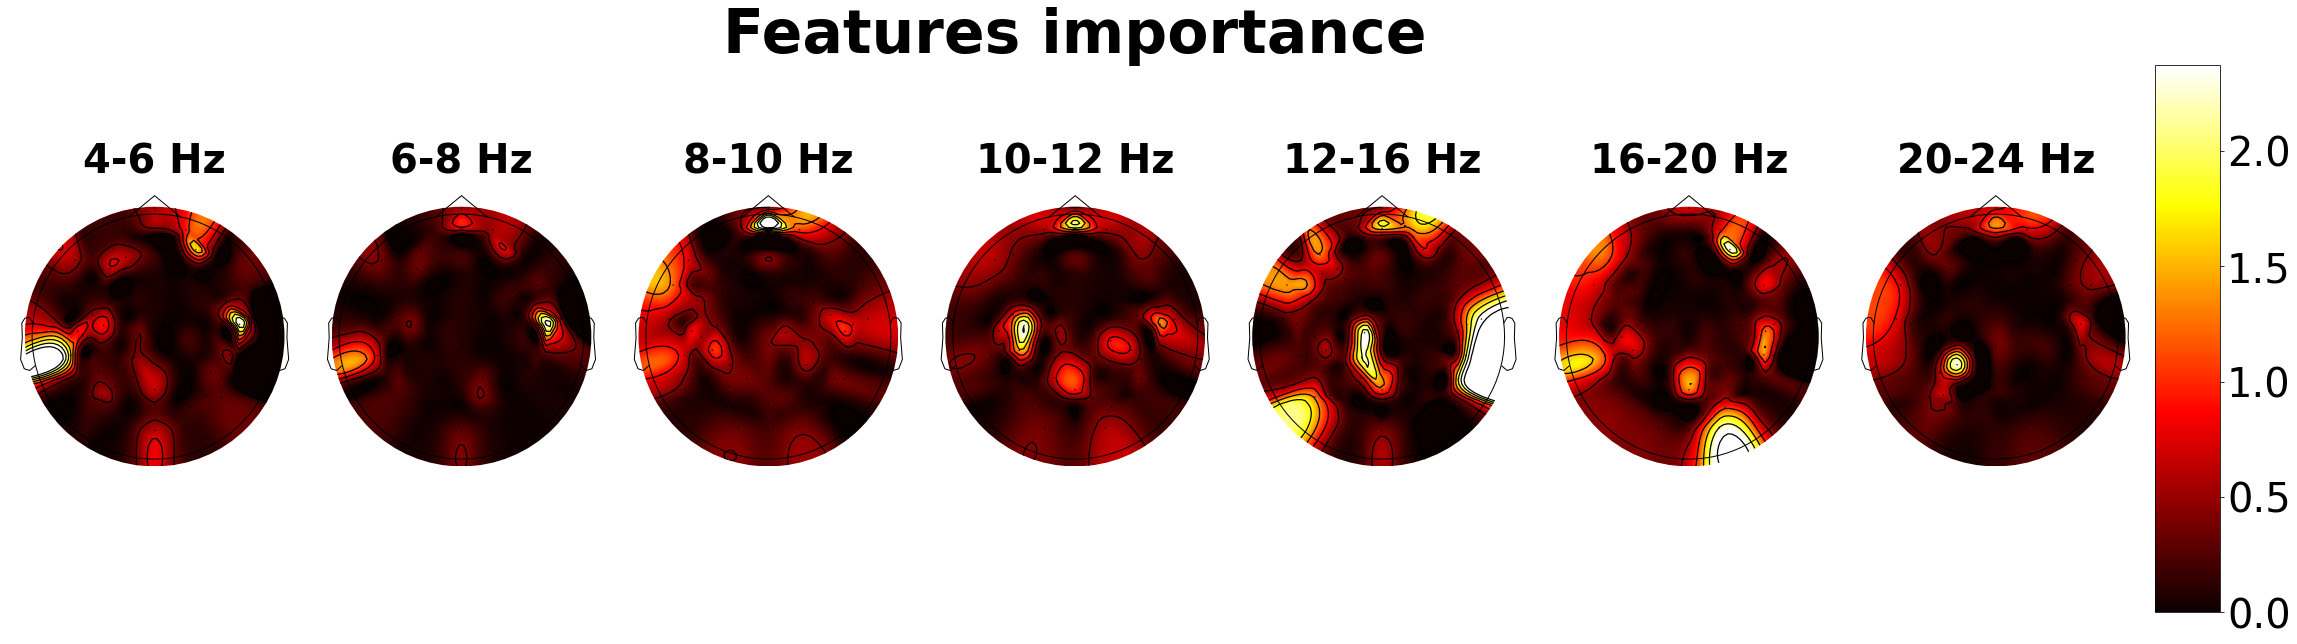

In [203]:
from matplotlib import cm
fig = plot_topo(fin_ar, info1)

In [204]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'feature_imp_resting_suc_not_suc.png'), format='png',
            bbox_inches='tight', dpi=600)
#plt.save(os.path.join(path_subj_topo, 'cluster_test_244_fin_3.png'), format='png', dpi=600)
plt.close(fig)

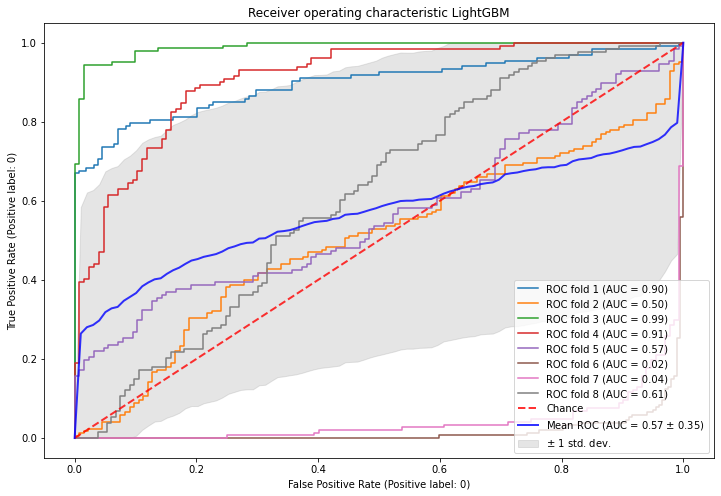

In [205]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

random_state = np.random.RandomState(0)

# Run classifier with cross-validation and plot ROC curves

fig, ax = plt.subplots(figsize=(12, 8))
for i, (tpr, fpr) in enumerate(zip(tprl, fprl)):
    viz = RocCurveDisplay.from_predictions(
        y_true=tpr,
        y_pred=fpr[:,0].tolist(),
        name=f"ROC fold {i+1}",
        pos_label = 0,
        ax=ax
    )
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic LightGBM",
)
ax.legend(loc="lower right")
plt.show()

In [206]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'lgb_roc_auc_resting_suc_not_suc.png'), format='png', bbox_inches='tight', dpi=600)

In [208]:
results_group.to_csv(os.path.join('/Users/ilyamikheev/Downloads/', 'res_lgb_suc_not_suc.csv'))

In [ ]:
# 19 channels
# delete FP1, FP2
path = '/Users/ilyamikheev/Downloads/19_CHANNEL_split_REST_open_for_Ilia'
files = [f for f in sorted(os.listdir(path))]
_ = files.pop(0)
indexes = []
for i,j in enumerate(files):
    indexes.append(re.search('(.+?)_', j).group(1))
chan_drop = ['O1', 'O2']
montage = mne.channels.make_standard_montage('standard_1020')
fr_bands = {   "theta1":  [4,6],
               "theta2":  [6,8],
               "alpha1": [8,10],
               "alpha2": [10,12],
               "beta1":  [12,16],
               "beta2":  [16,20],
               "beta3":  [20,24] }
mat = ['004','008','009','011','012','013','015','016']
not_mat = [x for x in indexes if x not in mat]
index_mat, index_not_mat = [indexes.index(i) for i in mat], [indexes.index(i) for i in not_mat]

In [69]:
def predict(x_train, x_test, y_train, y_test):
    results = np.zeros((1,4))
    model = make_pipeline( StandardScaler(),
                               LinearModel(LogisticRegressionCV(
                               Cs=list(np.power(10.0, np.arange(-10, 10))),
                               penalty='l2',
                               scoring='roc_auc',
                               random_state=0,
                               max_iter=10000,
                               fit_intercept=True,
                               solver='newton-cg',
                               class_weight='balanced',
                               tol=10
                                                                       )))
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    ac =  balanced_accuracy_score(y_test,y_predict)
    score = model.score(x_test,y_test)
    #cm=confusion_matrix(y_test,y_predict)
    #TN,TP,FN,FP = cm[1,1],cm[0,0],cm[1,0],cm[0,1]
    #results[0,0], results[0,1] = accuracy_score(y_test,y_predict), 0
    #results[0,2], results[0,3] = TP/float(TP+FN), TN/float(TN+FP)

    return ac, score, model, predictions
# plot topomap for each freq band

In [189]:
list_A, list_B = [], []
#index_mat, index_not_mat = [indexes.index(i) for i in mat], [indexes.index(i) for i in not_mat]
#new_mat = ['314', '326', '327', '328', '335', '315']
#new_not_mat = ['318','319','320','322','333','329']
new_mat = ['311', '316', '312', '334', '313', '332', '324', '337']
new_not_mat = ['314','327','326','335','329','319', '318', '320']
#new_mat = ['311', '312', '316', '317', '330', '334']
#new_not_mat = ['313','324','331','332','337','336']
#new_mat = ['326', '330', '316', '328', '314', '335', '327', '312', '317', '334']
#new_not_mat = ['333', '320', '319', '336', '331', '323', '313', '324', '325', '337']
index_mat, index_not_mat = [indexes.index(i) for i in new_mat], [indexes.index(i) for i in new_not_mat]
all_indexes = index_mat + index_not_mat
coefs_group = np.zeros((10,2,len(fr_bands),len(chan1)))
results_group_l = np.zeros((10,2))
#all_indexes_table = mat + not_mat
#all_indexes = np.array(all_indexes)
index_mat, index_not_mat = np.array(index_mat), np.array(index_not_mat)
tprs = []
aucs = []
fprl = []
tprl = []
for count, (s_ind_1, s_ind_2) in enumerate(zip(index_mat, index_not_mat)):
    mean_fpr = np.linspace(0, 1, 100)
    A =  np.concatenate(([np.stack([subj_list_features[j] for j in index_mat[index_mat!=s_ind_1]][i][ind],axis = 1)
                      for i in range(index_mat[index_mat!=s_ind_1].shape[0])]),axis=0)
    B =  np.concatenate(([np.stack([subj_list_features[j] for j in index_not_mat[index_not_mat!=s_ind_2]][i][ind],axis = 1)
                      for i in range(index_not_mat[index_not_mat!=s_ind_2].shape[0])]),axis=0)
    C1 = np.stack(subj_list_features[s_ind_1][ind], axis = 1)
    C2 = np.stack(subj_list_features[s_ind_2][ind], axis = 1)
    x_train = np.concatenate((A,B),axis=0)
    y_train = [0]*A.shape[0] + [1]*B.shape[0]
    x_test = np.concatenate((C1, C2),axis=0)
    y_test = [0]*C1.shape[0] + [1]*C2.shape[0]
    x_train = x_train.reshape(x_train.shape[0],-1)
    x_test = x_test.reshape(x_test.shape[0],-1)
    # test size 0.2
    x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.1)
    ac, auc, model, predictions = predict(x_train, x_test, y_train, y_test)
    fpr, tpr, _ = roc_curve(y_test, predictions[:,0], pos_label=0)
    fprl.append(predictions)
    tprl.append(y_test)
    roc_auc = metrics.auc(fpr, tpr)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    for name, i in zip(['patterns_', 'filters_'],[0,1]):
        coef = get_coef(model, name, inverse_transform=True)
        coefs_group[count,i,...] = coef.reshape(len(fr_bands),-1)
    results_group_l[count, 0] = ac
    results_group_l[count, 1] = auc

In [190]:

from sklearn.preprocessing import minmax_scale

In [191]:
a_lf = []
a_l = coefs_group[results_group_l[:, 1] > 0.5, ...]
s = a_l[0].shape
for i in range(len(a_l)):
    k = minmax_scale(a_l[i].reshape(2, -1), feature_range=(-1, 1), axis=1)
    a_lf.append(k.reshape(s))
fin_ar = np.mean(a_lf, axis=0)

In [192]:
def plot_patterns(ar):
    #vmin = - np.amax(ar)
    #vmax = np.amax(ar)
    vmax = 1
    vmin = -1
    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(30, 20))
    for name, pos, plot_name, ind in zip(('patterns_', 'filters_'),(0.82,0.5),
                                         ('Patterns','Filters'),(0,1)):
        for i,key in enumerate(list(fr_bands.keys())):
            a = mne.viz.plot_topomap(ar[ind,i,:],info,vmin=vmin,vmax=vmax, axes=axes[ind,i],
                                 show = False)
            axes[ind,i].set_title(label='{}-{} Hz'.format(*fr_bands[key]), fontdict = {'fontsize': 40, 'fontweight' : 'semibold'})
            mne.viz.tight_layout()
        plt.figtext(0.5,pos,'{}'.format(plot_name), va="center", ha="center", size=44, fontweight = 'semibold')
    m = cm.ScalarMappable(cmap='RdBu_r')
    m.set_array([vmin, vmax])
    cax = fig.add_axes([1, 0.3, 0.03, 0.38])
    cb = fig.colorbar(m, cax)
    cb.ax.tick_params(labelsize=40)
    return fig

/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/Users/ilyamikheev/.conda/envs/ihna_project/lib/python3.9/site-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhu

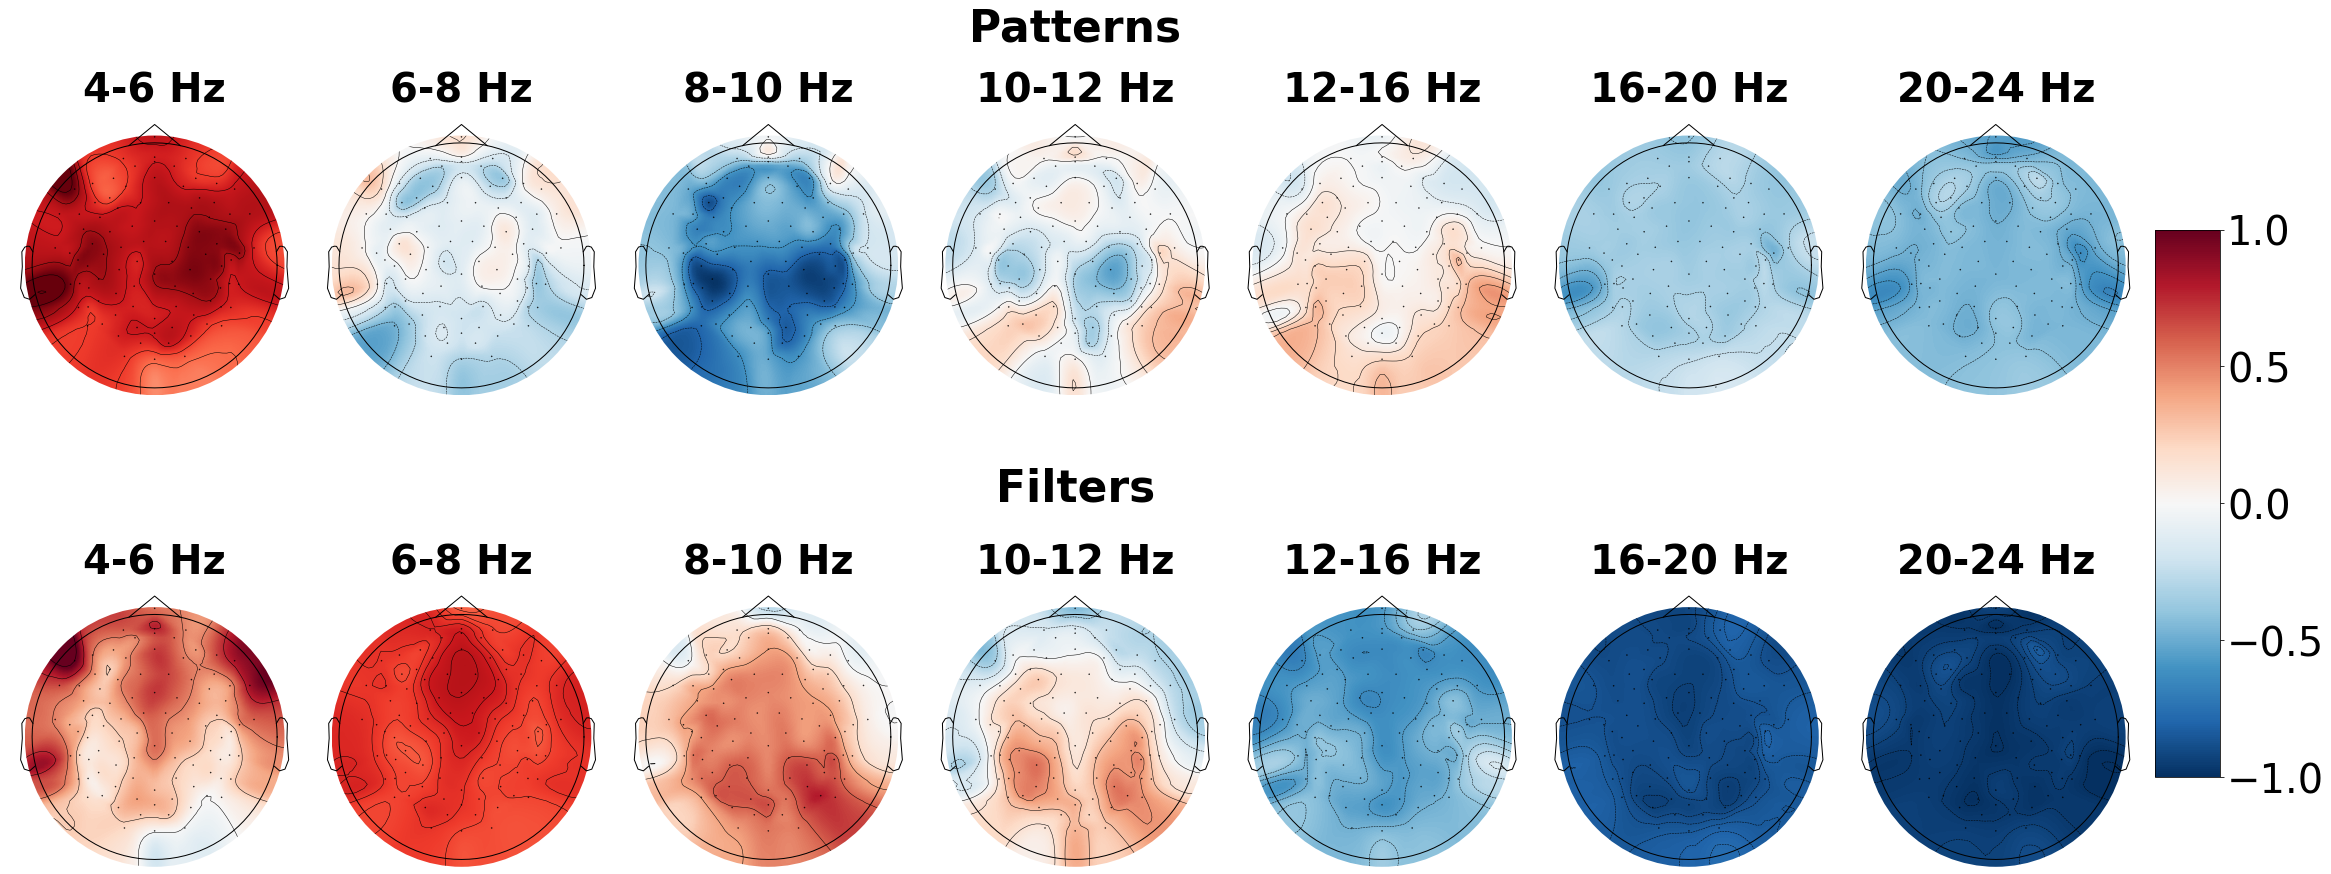

In [193]:
fig = plot_patterns(fin_ar)

In [194]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'feature_patterns_resting_suc_not_suc.png'), format='png', bbox_inches='tight', dpi=600)

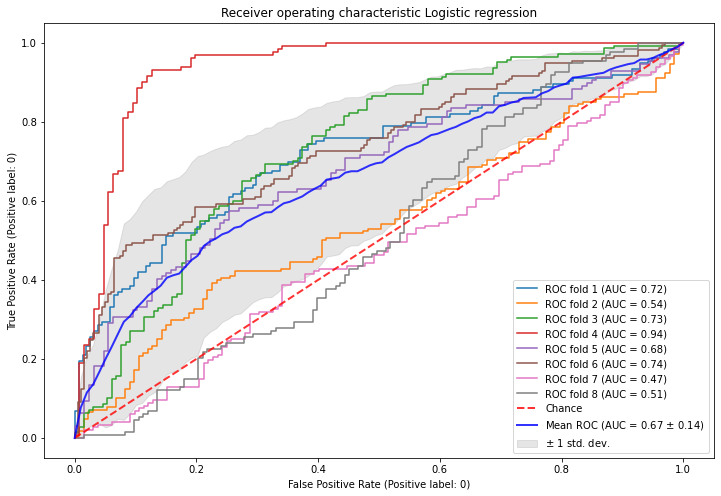

In [195]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

random_state = np.random.RandomState(0)

# Run classifier with cross-validation and plot ROC curves

fig, ax = plt.subplots(figsize=(12, 8))
for i, (tpr, fpr) in enumerate(zip(tprl, fprl)):
    viz = RocCurveDisplay.from_predictions(
        y_true=tpr,
        y_pred=fpr[:,0].tolist(),
        name=f"ROC fold {i+1}",
        pos_label = 0,
        ax=ax
    )
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic Logistic regression",
)
ax.legend(loc="lower right")
plt.show()

In [196]:
fig.savefig(os.path.join('/Users/ilyamikheev/Downloads/', 'linear_roc_auc_resting_suc_not_suc.png'), format='png', bbox_inches='tight', dpi=600)

In [197]:
results_group = pd.DataFrame(results_group_l, columns = ['accuracy', 'auc'] )

In [198]:
results_group.to_csv(os.path.join('/Users/ilyamikheev/Downloads/', 'res_suc_not_suc_lin.csv'))

In [111]:
len(subj_list_table[0][0])

7

In [113]:
subj_list_table[0][0][0].shape

(95,)

In [120]:
from mne.stats import permutation_cluster_test

In [130]:
new_mat = ['311', '312', '316', '317', '330', '334']
new_not_mat = ['313','324','331','332','337','336']

In [177]:
a1 = np.stack(subj_list_table)
res_ar = np.zeros_like(a1[0,0,...])
a2 = a1[:,0,...]
ll = []
for i in range(7):
    a3 = a2[:,i,:]
    b1 = a3[index_mat]
    b2 = a3[index_not_mat]
    T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([b1, b2], threshold = 7, out_type='mask',
                             n_permutations=1000)
    T_obs_plot = np.nan * np.ones_like(T_obs)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.05:
            T_obs_plot[c] = T_obs[c]
    np.nan_to_num(T_obs_plot, copy=False)
    if np.count_nonzero(T_obs_plot) > 0:
        ll.append(i)
        res_ar[i,:] = T_obs_plot
mr_ar = res_ar>0

stat_fun(H1): min=0.000367 max=1.386138
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.000044 max=1.651138
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.046010 max=6.155287
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.021324 max=4.851207
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.000000 max=3.909156
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.000000 max=0.847904
Running initial clustering
Found 0 clusters
stat_fun(H1): min=0.000002 max=0.811219
Running initial clustering
Found 0 clusters


/var/folders/hy/0hd117lj3b7b2wcntlvmhrw40000gn/T/ipykernel_9263/724514507.py:10: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_test([b1, b2], threshold = 7, out_type='mask',
/var/folders/hy/0hd117lj3b7b2wcntlvmhrw40000gn/T/ipykernel_9263/724514507.py:10: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_test([b1, b2], threshold = 7, out_type='mask',
/var/folders/hy/0hd117lj3b7b2wcntlvmhrw40000gn/T/ipykernel_9263/724514507.py:10: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_test([b1, b2], threshold = 7, out_type='mask',
/var/folders/hy/0hd117lj3b7b2wcntlvmhrw40000gn/T/ipykernel_9263/724514507.py:10: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_test([b1, b2], threshold = 7, out_type='mask',
/var/folders/hy/0hd117lj3b7b2wcntlvmhrw40000gn/T/ipykernel_9263/724514507.py:10:

In [178]:
 b1

array([[2.65854103e-04, 1.67644844e-04, 1.26386864e-04, 1.14572880e-04,
        3.02105097e-04, 2.55256871e-04, 1.33120934e-04, 1.89275945e-04,
        1.70499265e-04, 1.76113712e-04, 3.24621237e-04, 2.38863538e-04,
        2.51798270e-04, 1.52603470e-04, 5.11836754e-04, 1.57124577e-04,
        2.36255566e-04, 4.37861291e-04, 2.11479576e-04, 9.63035860e-05,
        3.50206962e-04, 1.09067428e-04, 2.22968885e-04, 4.12409695e-04,
        2.21427309e-04, 4.08015203e-04, 8.27648755e-04, 3.43895911e-04,
        2.74888315e-04, 2.20404294e-04, 4.24026100e-04, 3.05229788e-04,
        6.29461916e-04, 2.29967085e-04, 2.38595334e-04, 1.27047622e-04,
        3.37309877e-04, 5.41941993e-04, 2.60829408e-04, 1.21629272e-04,
        3.60763591e-04, 3.93803141e-04, 3.00739011e-04, 1.85429573e-04,
        3.80644454e-04, 3.41242209e-04, 2.37280781e-04, 2.66555968e-04,
        2.87360523e-04, 3.70020721e-04, 2.19363872e-04, 2.67320166e-04,
        1.99224415e-04, 2.13933419e-04, 4.40860892e-04, 1.131487

In [160]:
b2

array([[3.93492619e-04, 1.86101537e-04, 1.00232520e-04, 5.35058198e-05,
        3.19090983e-05, 4.13649722e-05, 5.26567200e-05, 1.10849837e-04,
        7.99299997e-05, 4.03456515e-05, 3.74075929e-05, 5.70203520e-05,
        1.08127390e-04, 4.95347588e-05, 8.70527741e-05, 1.40915781e-04,
        7.73582968e-05, 1.20642140e-04, 2.00273542e-04, 1.22646991e-04,
        1.51904020e-04, 2.10138942e-04, 1.91113695e-04, 1.78464230e-04,
        1.71339264e-04, 1.33029456e-04, 8.88072967e-05, 1.51119457e-04,
        2.50741102e-04, 2.49981554e-04, 1.46005124e-04, 1.17430499e-04,
        9.28451605e-05, 9.80040246e-05, 2.73761681e-04, 2.08217963e-04,
        1.00032305e-04, 1.09429756e-04, 5.00746063e-05, 2.17585933e-04,
        1.71507401e-04, 8.84442539e-05, 2.01031550e-04, 2.08959051e-04,
        1.72718144e-04, 2.03198436e-04, 1.64825519e-04, 9.79995198e-05,
        1.57913046e-04, 1.35294055e-04, 1.05598999e-04, 9.43183024e-05,
        5.55761014e-05, 6.73518027e-05, 5.55578785e-05, 7.049731

In [179]:
res_ar

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [134]:
def plot_topo(ar, info):
    #vmin = np.amin(ar)
    vmin = -np.amax(ar)
    vmax = np.amax(ar)
    fig, axes = plt.subplots(nrows=1, ncols=len(ll), figsize=(30, 20))
    ss = 0
    for i, key in enumerate(list(fr_bands.keys())):
        if i in ll:
            evoked = mne.EvokedArray(ar[i,:].reshape(-1,1),
                             info, tmin=0.)
            a = evoked.plot_topomap(axes=axes[ss],time_format=None, colorbar = False,  times=[0], size = 5, show_names = True,
                                 show = False)
            axes[ss].set_title(label = '{}-{} Hz'.format(*fr_bands[key]), fontdict = {'fontsize': 40, 'fontweight' : 'semibold'})
            mne.viz.tight_layout()
            ss+=1
    m = cm.ScalarMappable(cmap='Reds')
    m.set_array([vmin, vmax])
    cax = fig.add_axes([1, 0.3, 0.03, 0.38])
    cb = fig.colorbar(m, cax)
    cb.ax.tick_params(labelsize=40)
    #plt.figtext(0.5, 1.0, '{}'.format('Sagnificant clusters'), va="center", ha="center", size=60, fontweight = 'semibold')
    return fig

In [180]:
fig = plot_topo(res_ar, info1)

ValueError: Number of columns must be a positive integer, not 0

<Figure size 2160x1440 with 0 Axes>

In [ ]:
np.concatenate(([np.stack([subj_list_features[j] for j in index_mat[index_mat!=s_ind_1]][i][ind],axis = 1)

In [115]:
np.stack(subj_list_table).shape

(26, 1, 7, 95)

In [181]:
k_l= [0.23, 0.21, 0.24, 0.28, 0.27, 0.26, 0.22, 0.27, 0.29, 0.30, 0.25, 0.33, 0.33, 0.31, 0.32, 0.35, 0.33, 0.31, 0.28, 0.29, 0.31, 0.33, 0.38, 0.39, 0.42, 0.44, 0.48, 0.48, 0.47, 0.44, 0.41, 0.35, 0.31, 0.26, 0.26, 0.25, 0.27, 0.28, 0.27, 0.27, 0.26]

In [182]:
len(k_l)

41

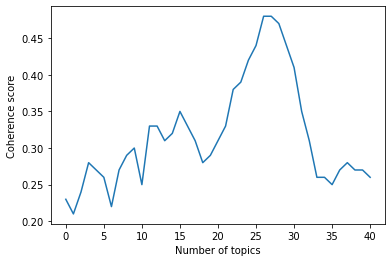

In [188]:
plt.plot(k_l)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.savefig('/Users/ilyamikheev/Downloads/coh_top.png', format='png', bbox_inches='tight', dpi=600)